## <span style='color:#ff5f27'> 📝 Imports

In [1]:
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import os
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix,
)

## <span style="color:#ff5f27;"> 🔮 Connecting to Hopsworks Feature Store </span>

In [2]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://snurran.hops.works/p/11385
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
cheque_fg = fs.get_feature_group(
    name="cheque_fg",
    version=1,
)

## <span style="color:#ff5f27;">🪄 Feature View Creation </span>


In [4]:
# Get or create the 'cheque_fraud_detection' feature view
feature_view = fs.get_or_create_feature_view(
    name="cheque_fraud_detection",
    version=1,
    description='Parsed Cheque Data for Fraud Detection',
    query=cheque_fg.select(["spelling_is_correct", "amount_letter_number_match", "valid"]),
    labels=['valid'],
)

Feature view created successfully, explore it at 
https://snurran.hops.works/p/11385/fs/11333/fv/cheque_fraud_detection/version/1


In [5]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size=0.2
)
X_train.head(3)

Finished: Reading data from Hopsworks, using ArrowFlight (0.85s) 


,spelling_is_correct,amount_letter_number_match
0,True,False
1,True,True
2,True,True


In [6]:
y_train.head(3)

,valid
0,0
1,1
2,1


## <span style="color:#ff5f27;">🧬 Model Building </span>


In [7]:
# Create an instance of the XGBoost Classifier
xgb_classifier = XGBClassifier()

# Fit the XGBoost Classifier to the training data
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">⚖️ Model Validation </span>

In [8]:
# Make predictions on the testing set
y_pred = xgb_classifier.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Optionally, display a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the metrics
print(f"⛳️ Accuracy: {accuracy:.2f}")
print(f"⛳️ Precision: {precision:.2f}")
print(f"⛳️ Recall: {recall:.2f}")
print(f"⛳️ F1 Score: {f1:.2f}")
print(f"⛳️ Confusion Matrix:\n{cm}")

⛳️ Accuracy: 0.96
⛳️ Precision: 0.95
⛳️ Recall: 0.97
⛳️ F1 Score: 0.95
⛳️ Confusion Matrix:
[[ 746    0]
 [  86 1168]]


In [9]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "cheque_fraud_detection_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

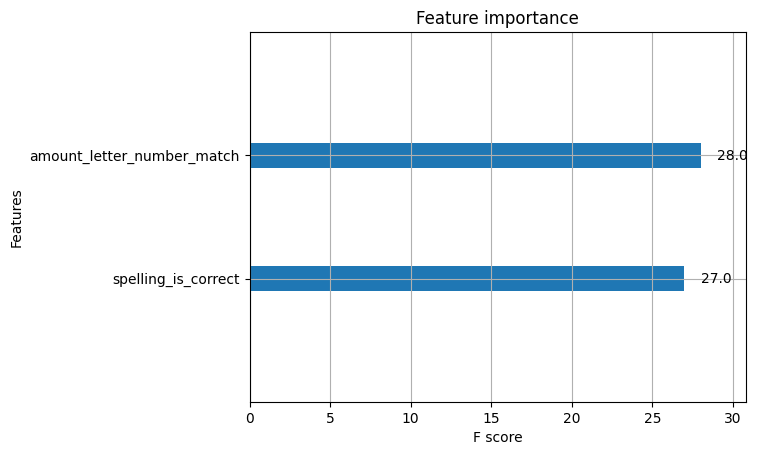

In [10]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_classifier)

feature_importance_path = images_dir + "/feature_importance.png"

plt.savefig(feature_importance_path)
plt.show()

## <span style="color:#ff5f27;">🗄 Model Registry </span>

In [11]:
# Retrieve the model registry
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [12]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Create input and output schemas using the 'Schema' class for features and target variable
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Create a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(
    input_schema=input_schema, 
    output_schema=output_schema,
)

# Convert the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [13]:
xgb_classifier.save_model(model_dir + "/model.json")

In [14]:
res_dict = { 
    "Accuracy": str(round(accuracy, 2)),
    "Precision": str(round(precision, 2)),
    "Recall": str(round(recall, 2)),
    "F1 Score": str(round(f1, 2)),
}

In [15]:
cheque_fraud_detection_model = mr.python.create_model(
    name="cheque_fraud_detection_model", 
    metrics=res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Cheque Fraud Detection Model",
)

# Saving the model artifacts to the 'cheque_fraud_detection_model' directory in the model registry
cheque_fraud_detection_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://snurran.hops.works/p/11385/models/cheque_fraud_detection_model/1


Model(name: 'cheque_fraud_detection_model', version: 1)

---